In [544]:
import os
from ccdproc import CCDData
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling import models, fitting
from astropy import units as u
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky
from astroquery.gaia import Gaia
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.table import Table
from astropy.visualization import SqrtStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from goodman_pipeline.core import ra_dec_to_deg
from astropy.wcs import WCS
from astropy.wcs.utils import fit_wcs_from_points
from stsci.stimage import xyxymatch

plt.style.use('dark_background')

for _file in sorted(os.listdir('./data/tpsec_sv/')):
    print(_file)

SV_OBJ0021.fits


### Notes from Sean
used these to define the astrometric solution for the TSpec SV.  Marco noted that he had pixel scales of -0.259 and -0.241 which are numbers that he got from the commissioning data on the Blanco.
```
CTYPE1 <RA---TAN>
CTYPE2 <DEC--TAN>
CRPIX1 <439.5>
CRPIX2 <857.5>
CRVAL1 <Value of TELRA converted to decimal degrees>
CRVAL2 <Value of TELDEC converted to decimal degrees>
PIXSCAL1 < -0.255 Unbinned pixel scale for axis 1 (arcsec/pix) >
PIXSCAL2 <  0.255 Unbinned pixel sacel for axis 2 (arcsec/pix) >
CDELT1   < pixel scale in degrees for axis 1 PIXSCAL1 / 3600. >
CDELT2   < pixel scale in degress for axis 2 PIXSCAL2 / 3600. >

===
Not to be added, but need to calculate for CD matrix
PA = IPA - 90 where IPA is already a KEYWORD

If trig functions are in radians and not degree
PA = ((IPA - 90.)*pi)/180. where IPA is already a KEYWORD
===

CD1_1 = CDELT1 * cos(PA)
CD1_2 = -CDELT1 * sin(PA)
CD2_1 = CDELT2 * sin(PA)
CD2_2 = CDLET2 * cos(PA)
```

I would maybe go through and add the keywords to an SV header (CTYPEn, CRPIXn, CRVALn, PIXSCALEn, CDELTn, and CDn_m) and then see what happens when you run sextractor and scamp.

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


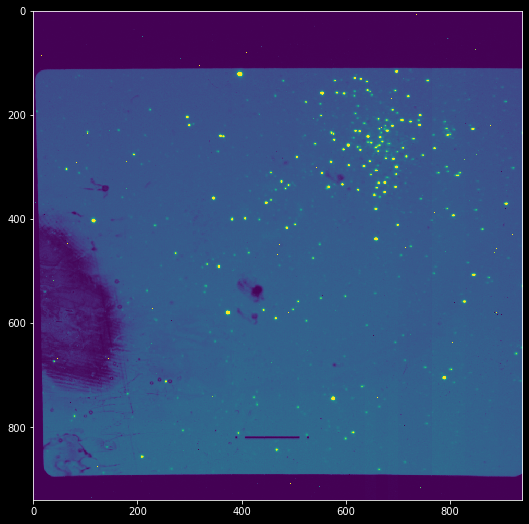

In [571]:
def show_fits(ccd, z1=None, z2=None):
    scale = ZScaleInterval()
    dz1, dz2 = scale.get_limits(ccd)
    if z1 is None:
        z1 = dz1
    else:
        z2 = float(z2)
    if z2 is None:
        z2 = dz2
    else:
        z2 = float(z2)
        
    fig, ax = plt.subplots(figsize=(16,9))
    ax.imshow(ccd.data, clim=(z1, z2))
    
# mask_out_file = 'data/case_1/0347_SN2020uxz-23-10-2020_mask_out.fits'
mask_out_file = 'data/tpsec_sv/SV_OBJ0021.fits'

ccd = CCDData.read(mask_out_file, unit='adu')
show_fits(ccd)

# Add raw solution

In [572]:
from astropy.io.fits.header import Header

wcs_string = ''
header = Header()
with open('tspec_ldac.head', 'r') as head_file:
    for line in head_file.readlines():
        print(repr(line))
        if '=' in line:
            key, content = line.rstrip().split('=')
            value, comment = content.split(' / ')
            try:
                header.set(key, value=int(value), comment=comment)
            except ValueError:
                try:
                    header.set(key, value=float(value), comment=comment)
                except ValueError:
                    header.set(key, value=value.strip(), comment=comment)
                    
            
            
        else:
            pass
#             print(line)
#     lines = head_file.readlines()
#     wcs_lines = lines[3:17]
#     wcs_lines.append(lines[-1])
#     wcs_string = ''.join(wcs_lines)
#     print(wcs_string)

#     wcs_string = head_file.read()

# print(wcs_string)
# hdr = Header.fromstring(wcs_string, sep='\n')
# hdr
header

'HISTORY   Astrometric solution by SCAMP version 2.10.0 (2021-02-18)\n'
'COMMENT   (c) 2010-2018 Sorbonne Université/Université de Bordeaux/CNRS\n'
'COMMENT   \n'
'EQUINOX =        2000.00000000 / Mean equinox                                  \n'
"RADESYS = 'ICRS    '           / Astrometric system                            \n"
"CTYPE1  = 'RA---TAN'           / WCS projection type for this axis             \n"
"CTYPE2  = 'DEC--TAN'           / WCS projection type for this axis             \n"
"CUNIT1  = 'deg     '           / Axis unit                                     \n"
"CUNIT2  = 'deg     '           / Axis unit                                     \n"
'CRVAL1  =   7.723545303811E+01 / World coordinate on this axis                 \n'
'CRVAL2  =  -6.872111925909E+01 / World coordinate on this axis                 \n'
'CRPIX1  =   4.340000000000E+02 / Reference pixel on this axis                  \n'
'CRPIX2  =   8.200000000000E+02 / Reference pixel on this axis                  \

EQUINOX =               2000.0 / Mean equinox                                   
RADESYS = '''ICRS    '''       / Astrometric system                             
CTYPE1  = '''RA---TAN'''       / WCS projection type for this axis              
CTYPE2  = '''DEC--TAN'''       / WCS projection type for this axis              
CUNIT1  = '''deg     '''       / Axis unit                                      
CUNIT2  = '''deg     '''       / Axis unit                                      
CRVAL1  =    77.23545303810999 / World coordinate on this axis                  
CRVAL2  =      -68.72111925909 / World coordinate on this axis                  
CRPIX1  =                434.0 / Reference pixel on this axis                   
CRPIX2  =                820.0 / Reference pixel on this axis                   
CD1_1   = -7.2228377076440E-05 / Linear projection matrix                       
CD1_2   =   -1.09355695203E-07 / Linear projection matrix                       
CD2_1   =  -3.016855706352E-

In [573]:
ccd.header +=header
ccd.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  940                                                  
NAXIS2  =                  940                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
NEXTEND =                    0 / Number of extensions                           
OBJECT  = 'none    '           / object title                                   
PROPID  = 'NA      '           / propose ID                                     
OBSID   = 'obs.20210225.235212' / sequence ID                                   
FILENAME= 'SV_OBJ0021.fits'    / fits file name                                 
EXPID   = 'ct4m.tspec.202102

In [574]:
ccd.write('raw_wcs_header.fits')

In [575]:
twcs = WCS(ccd.header)

InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 2747 of file cextern/wcslib/C/wcs.c:
Unrecognized projection code (-TA in CTYPE1).


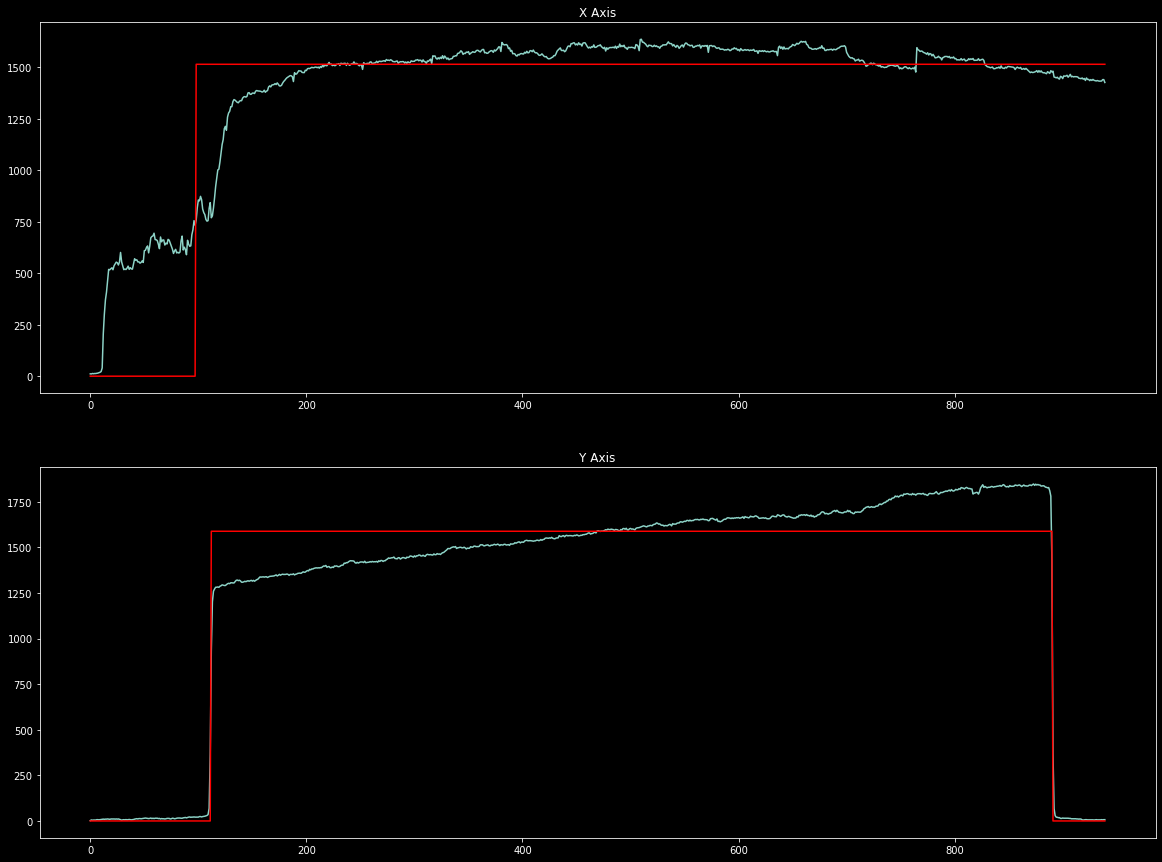

In [570]:

pixel_scale = Angle(0.26, u.arcsec) # arcseconds
x, y = ccd.data.shape
x_median = np.median(ccd.data[int(x/2. - 0.2 * x): int(x/2. + 0.2 * x),:], axis=0)
y_median = np.median(ccd.data[:, int(x/2. - 0.2 * x): int(x/2. + 0.2 * x)], axis=1)

# fit a box model
x_box_model = models.Box1D(amplitude=np.max(x_median), x_0=int(x/2.), width=int(x/2.))
y_box_model = models.Box1D(amplitude=np.max(y_median), x_0=int(y/2.), width=int(y/2.))

box_fitter = fitting.SimplexLSQFitter()

x_box_fitted = box_fitter(x_box_model, range(x), x_median)
y_box_fitted = box_fitter(y_box_model, range(y), y_median)

fig, (ax1, ax2) = plt.subplots(2, 1 ,figsize=(20,15))
ax1.set_title('X Axis')
ax1.plot(x_median)
ax1.plot(x_box_fitted(range(x)), color='r')
ax2.set_title('Y Axis')
ax2.plot(y_median)
ax2.plot(y_box_fitted(range(y)), color='r')
plt.show()

In [431]:
ra_deg, dec_deg = ra_dec_to_deg(right_ascension=ccd.header['RA'], declination=ccd.header['DEC'])
ref_coord = SkyCoord(ra_deg, dec_deg, unit=(u.degree, u.degree), frame='icrs')

print(ra_deg, dec_deg)
print(ref_coord)

77.235225 -68.72090833333333
<SkyCoord (ICRS): (ra, dec) in deg
    (77.235225, -68.72090833)>


In [432]:
print(type(pixel_scale))
print(pixel_scale)
print(pixel_scale.deg)

<class 'astropy.coordinates.angles.Angle'>
0.26arcsec
7.222222222222222e-05


In [433]:
print(x_box_fitted)
print(y_box_fitted)

Model: Box1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0              width      
    ------------------ ---------------- -----------------
    1514.9251766776733 557.694185284553 920.4645146713162
Model: Box1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             x_0               width      
    ------------------ ------------------ -----------------
    1588.4685533758582 501.03714375611946 778.6726490272789


In [434]:
serial_binning, parallel_binning = [1,1] # [int(x) for x in ccd.header['CCDSUM'].split()]
print("Serial Binning: {} Paralell Binning: {}".format(serial_binning, parallel_binning))
x_width = x_box_fitted.width.value * (serial_binning * pixel_scale)
y_width = y_box_fitted.width.value * (parallel_binning * pixel_scale)

background_level = (x_box_fitted.amplitude.value + y_box_fitted.amplitude.value) / 2.
print(f"Background level: {background_level}")

Serial Binning: 1 Paralell Binning: 1
Background level: 1551.6968650267659


In [435]:
w = WCS(naxis=2)
w.wcs.crpix = [x/2. - 36, y -120]
w.wcs.cdelt = np.array([-pixel_scale.deg * serial_binning, pixel_scale.deg * parallel_binning])
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w.wcs.crval = [ra_deg, dec_deg]
w.array_shape = ccd.data.shape
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 77.235225  -68.72090833333333  
CRPIX : 434.0  820.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -7.222222222222222e-05  7.222222222222222e-05  
NAXIS : 940  940

In [436]:
ccd.wcs = w
ccd.write(mask_out_file, overwrite=True)
print(mask_out_file)

# re load file

ccd = CCDData.read(mask_out_file, unit='adu')
# ccd.header

data/tpsec_sv/SV_OBJ0021.fits
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


1217.0339595859805 1465.0 639.4585430130403


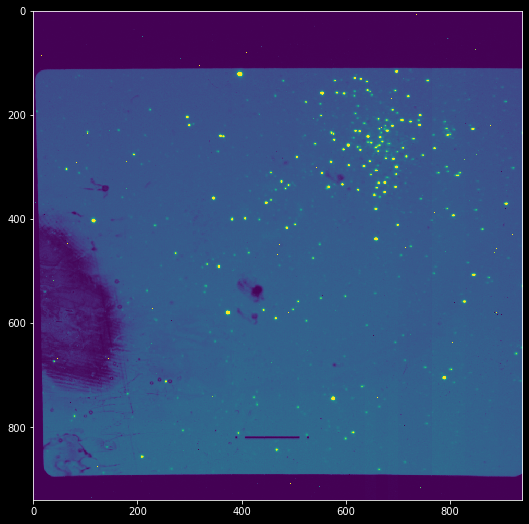

In [437]:
mean, median, std = sigma_clipped_stats(ccd.data, sigma=3.0)
print(mean, median, std)
show_fits(ccd)


# Find sources using sextractor

In [438]:
import subprocess
from threading import Timer
from goodman_pipeline.core import SaturationValues

saturation_values = SaturationValues()
serial_binning, parallel_binning = [1,1] #[int(x) for x in ccd.header['CCDSUM'].split()]

catalog_name = "tspec_ldac.cat" ## OK
catalog_type = "FITS_LDAC"
# catalog_name = "tspec_ascii.cat" ## OK
# catalog_type = "ASCII_HEAD"
threshold_type = 'ABSOLUTE' ## OK
detection_threshold = 3. * std
pixels_above_threshold = 6
# pixels_below_threshold = 50
seeing_fwhm = 1 # ccd.header['SEEING'] # 5 * serial_binning ## OK

# background
background_type='MANUAL' ##  OK
background_value = 1000 # background_level ## OK

gain = ccd.header['GAIN'] ## OK
# pixel_scale = 0.26 * serial_binning # arcsec ## OK
saturation_level = 50000 # saturation_values.get_saturation_value(ccd)
parameters_file = 'data/case_1/default.param'

# print(ccd.header['CCDSUM'])

sex_command = f"sex {mask_out_file} "\
              f" -CATALOG_NAME {catalog_name}"\
              f" -CATALOG_TYPE {catalog_type}"\
              f" -PARAMETERS_NAME {parameters_file} "\
              f" -DETECT_THRESH {detection_threshold} "\
              f" -DETECT_MINAREA {pixels_above_threshold} "\
              f" -THRESH_TYPE {threshold_type}"\
              f" -FILTER N"\
              f" -GAIN {gain}"\
              f" -BACK_TYPE {background_type}"\
              f" -BACK_VALUE {background_value}"\
              f" -SEEING_FWHM {seeing_fwhm}"\
              f" -PIXEL_SCALE {0.26}"\
              f" -SATUR_LEVEL {saturation_level}"

          # f" -DETECT_MAXAREA {pixels_below_threshold} "\
#               f" -CATALOG_TYPE {catalog_type}"\




In [439]:
def kill_process(process):
    print('Process timed out')
    process.kill()
    
def call_subproces(command):
    print(command)
    try:
        sub_process = subprocess.Popen(command.split(),
                                       stdout=subprocess.PIPE, 
                                       stderr=subprocess.PIPE)
    except OSError as error:
        print(error)
    
    process_timer = Timer(10, kill_process, [sub_process])
    try:
        #     sex_timer.start()
        stdout, stderr = sub_process.communicate()
    finally:
        process_timer.cancel()
    
    if stdout != b'':
        print(stdout)
    if stderr != b'':
        print(stderr.decode('utf-8'))
    
    

In [440]:
call_subproces(sex_command)

sex data/tpsec_sv/SV_OBJ0021.fits  -CATALOG_NAME tspec_ldac.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME data/case_1/default.param  -DETECT_THRESH 1918.375629039121  -DETECT_MINAREA 6  -THRESH_TYPE ABSOLUTE -FILTER N -GAIN 1.9 -BACK_TYPE MANUAL -BACK_VALUE 1000 -SEEING_FWHM 1 -PIXEL_SCALE 0.26 -SATUR_LEVEL 50000

> WARNING: default.sex not found, using internal defaults

> 
----- SExtractor 2.25.0 started on 2021-03-02 at 00:55:28 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for SV_OBJ0021.fits
----- Measuring from: SV_OBJ0021.fits
      "none" / no ext. header / 940x940 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1000       RMS: 43.3388    / Threshold: 1918.38    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Li

# Match sources using SCAMP and GAIA DR2

In [526]:
# astrometric_reference_catalog = "GAIA-DR2"
astrometric_reference_catalog = "2MASS"
scamp_command = f"scamp {catalog_name} -ASTREF_CATALOG {astrometric_reference_catalog} -ASTREFMAG_LIMITS 8.0,18 -SOLVE_PHOTOM N"




In [527]:
call_subproces(scamp_command)

scamp tspec_ldac.cat -ASTREF_CATALOG 2MASS -ASTREFMAG_LIMITS 8.0,18 -SOLVE_PHOTOM N

> WARNING: scamp.conf not found, using internal defaults


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- SCAMP 2.10.0 started on 2021-03-02 at 13:02:15 with 12 threads

> 
----- 1 input:
> Examining Catalog tspec_ldac.cat

> WARNING: FLAGS parameter not found in catalog tspec_ldac.cat

tspec_ldac.cat:  "none               "  no ext. header   1 set     165 detections

----- 165 detections loaded
> Grouping fields on the sky ...
> Grouping fields: field 1/1, 0 group
> 

----- 1 instrument found for astrometry:

Instrument A1 :
1 extension
FILTER  =                                                                       
QRUNID  =                                                                       

----- 1 instrument found for photometry:

Instrument P1 :
FILTER  =                              

# Load astrometric solution and add it to file

In [528]:
!ls *.head

sample.head  tspec_ldac.head


In [529]:

from astropy.io.fits.header import Header

wcs_string = ''
with open('tspec_ldac.head', 'r') as head_file:
    lines = head_file.readlines()
    wcs_lines = lines[3:17]
    wcs_lines.append(lines[-1])
    wcs_string = ''.join(wcs_lines)
    print(wcs_string)

# wcs_string = head_file.read()

# print(wcs_string)
hdr = Header.fromstring(wcs_string)

# hdr.remove('HISTORY')
hdr

EQUINOX =        2000.00000000 / Mean equinox                                  
RADESYS = 'ICRS    '           / Astrometric system                            
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis             
CTYPE2  = 'DEC--TAN'           / WCS projection type for this axis             
CUNIT1  = 'deg     '           / Axis unit                                     
CUNIT2  = 'deg     '           / Axis unit                                     
CRVAL1  =   7.723545303811E+01 / World coordinate on this axis                 
CRVAL2  =  -6.872111925909E+01 / World coordinate on this axis                 
CRPIX1  =   4.340000000000E+02 / Reference pixel on this axis                  
CRPIX2  =   8.200000000000E+02 / Reference pixel on this axis                  
CD1_1   =  -7.222837707644E-05 / Linear projection matrix                      
CD1_2   =  -1.093556952030E-07 / Linear projection matrix                      
CD2_1   =  -3.016855706352E-08 / Linear 

EQUINOX =        2000.00000000 / Mean equinox                                  

RADESYS = 'ICRS    '           / Astrometric system                            

CTYPE1  = 'RA---TAN'           / WCS projection type for this axis             

CTYPE2  = 'DEC--TAN'           / WCS projection type for this axis             

CUNIT1  = 'deg     '           / Axis unit                                     

CUNIT2  = 'deg     '           / Axis unit                                     

CRVAL1  =   7.723545303811E+01 / World coordinate on this axis                 

CRVAL2  =  -6.872111925909E+01 / World coordinate on this axis                 

CRPIX1  =   4.340000000000E+02 / Reference pixel on this axis                  

CRPIX2  =   8.200000000000E+02 / Reference pixel on this axis                  

CD1_1   =  -7.222837707644E-05 / Linear projection matrix                      

CD1_2   =  -1.093556952030E-07 / Linear projection matrix                      

CD2_1   =  -3.016855706352E-

In [530]:
new_wcs = WCS(hdr)
new_wcs.array_shape = ccd.data.shape
new_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 77.23545303811  -68.72111925909  
CRPIX : 434.0  820.0  
CD1_1 CD1_2  : -7.222837707644e-05  -1.09355695203e-07  
CD2_1 CD2_2  : -3.016855706352e-08  7.208546796354e-05  
NAXIS : 940  940

In [531]:
ccd.wcs = new_wcs
ccd.write('tspec_new_file.fits', overwrite=True)



#  Load sextractor sources for previsualization

In [532]:
catalog = Table.read(catalog_name, format="fits", hdu='LDAC_OBJECTS')

In [533]:
catalog.show_in_notebook()

idx,XWIN_IMAGE,YWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,FLUX_AUTO,FLUXERR_AUTO,CLASS_STAR
,pix,pix,pix,pix,deg,ct,ct,
0,698.2845,118.3676,0.00620,0.00587,-5.34,236899,685.7717,1.000
1,664.1067,880.3524,0.01814,0.01812,40.20,276657,812.5583,1.000
2,209.8628,857.2454,0.01322,0.01320,65.83,426536,959.8571,1.000
3,468.3239,844.2083,0.01455,0.01452,60.08,393198,923.6159,1.000
4,600.1032,822.3689,0.01685,0.01680,9.51,238363,745.3689,1.000
5,525.0316,814.4628,0.01763,0.01761,47.61,117484,549.7731,1.000
6,394.8824,811.2177,0.01687,0.01680,58.94,290743,838.6606,1.000
7,614.4387,810.8156,0.01497,0.01495,17.73,377789,921.2561,1.000
8,287.9289,806.6829,0.01717,0.01714,-80.65,186904,664.8995,1.000


## Convert to pandas

In [534]:
pd_catalog = catalog.to_pandas()
pd_catalog = pd_catalog.sort_values(by='FLUX_AUTO')
pd_catalog

,XWIN_IMAGE,YWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,FLUX_AUTO,FLUXERR_AUTO,CLASS_STAR
21,41.232961,674.399750,0.009732,0.009668,43.008327,31806.0,220.613571,0.999750
33,938.911192,529.879175,0.016162,0.013737,89.077278,57350.0,352.274048,0.999787
23,938.063917,648.124626,0.018036,0.016450,88.389107,62286.0,381.415070,0.999713
161,480.498133,136.500383,0.017196,0.017022,18.747612,65062.0,440.334991,0.999660
156,617.487458,156.557204,0.017240,0.017103,-2.548814,74337.0,452.118622,0.999661
120,769.212661,239.772505,0.019205,0.018979,-5.514473,78894.0,480.860687,0.999647
148,551.874116,180.673259,0.017355,0.017166,5.148139,79825.0,483.316925,0.999716
136,790.463361,214.612477,0.018074,0.017807,-15.416771,80263.0,459.659332,0.999646
145,699.427400,197.867805,0.017295,0.017056,7.199974,80724.0,468.019623,0.999662
67,466.622142,345.255406,0.017593,0.017520,36.496998,83387.0,463.475098,0.999648


## Plot sources in pixel space

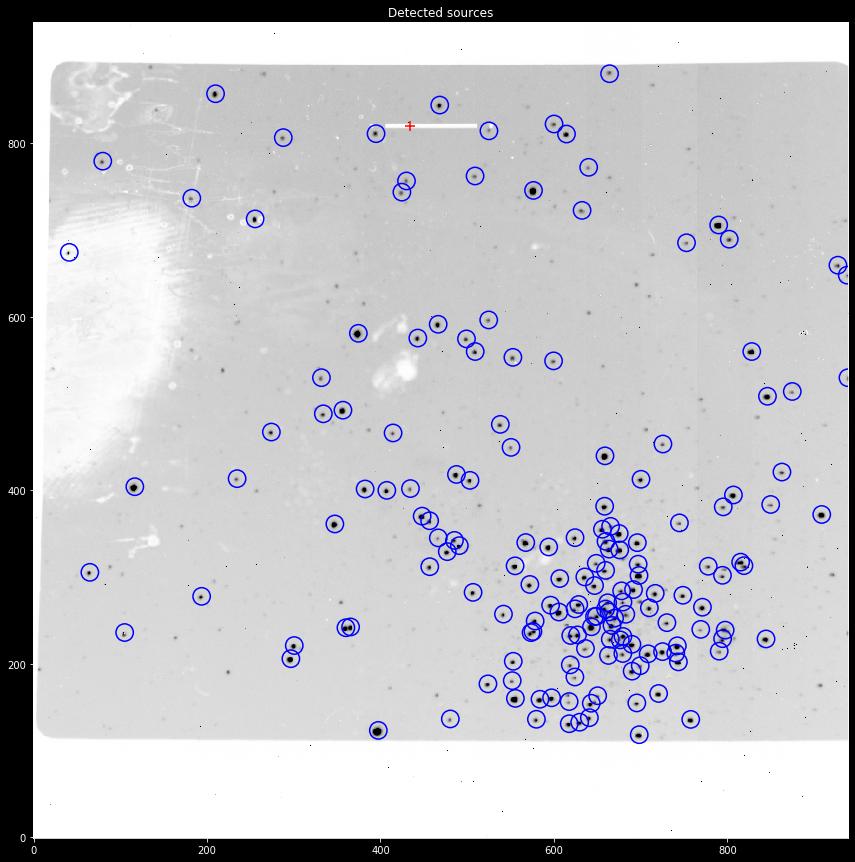

In [535]:
positions = np.transpose((pd_catalog['XWIN_IMAGE'], pd_catalog['YWIN_IMAGE']))
source_positions = (pd_catalog['XWIN_IMAGE'], pd_catalog['YWIN_IMAGE'])
# print(positions)
apertures = CircularAperture(positions, r=10.)
scale = ZScaleInterval()
z1, z2 = scale.get_limits(ccd)
# norm = ImageNormalize(stretch=SqrtStretch())
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title("Detected sources")
ax.scatter(x/2. - 36, y -120, color='r', marker="+",s=120)
ax.imshow(ccd.data, cmap='Greys', origin='lower', clim=(z1, z2),# norm=norm,
           interpolation='nearest')
# ax.set_xlim(420, 1100)
# ax.set_ylim(200, 1300)
apertures.plot(color='b', lw=1.5, alpha=1)

## Convert pixel coordinates to RA DEC

In [536]:
ccd_sky_coords = new_wcs.pixel_to_world(pd_catalog['XWIN_IMAGE'], pd_catalog['YWIN_IMAGE'])
# x_ref_pix = 

In [537]:
print(x_width, y_width)

239.321arcsec 202.455arcsec


In [538]:
center_coords = new_wcs.pixel_to_world(x/2., y/2.)
print(center_coords)
scicoord = SkyCoord(ra=ra_deg, dec=dec_deg, unit=(u.degree, u.degree), frame='icrs')
print(scicoord)
width = u.Quantity(x_width, u.deg)
height = u.Quantity(y_width, u.deg)
print(width/pixel_scale.arcsec, height/pixel_scale.arcsec)
Gaia.ROW_LIMIT = -1
r = Gaia.query_object_async(coordinate=center_coords, width=width, height=height)

print(r)

<SkyCoord (ICRS): (ra, dec) in deg
    (77.22817812, -68.74624734)>
<SkyCoord (ICRS): (ra, dec) in deg
    (77.235225, -68.72090833)>
0.255684587408699 deg 0.21629795806313304 deg
INFO: Query finished. [astroquery.utils.tap.core]
         dist             solution_id     ... epoch_photometry_url
                                          ...                     
--------------------- ------------------- ... --------------------
0.0007442525424033397 1635721458409799680 ...                     
0.0011122190159213012 1635721458409799680 ...                     
0.0011334449608878562 1635721458409799680 ...                     
0.0012061371968479736 1635721458409799680 ...                     
0.0012954167117128924 1635721458409799680 ...                     
0.0016092323206601056 1635721458409799680 ...                     
0.0016318502105537355 1635721458409799680 ...                     
0.0016560992896612013 1635721458409799680 ...                     
0.0016588215482949227 16357214584

In [539]:
r = r[r['phot_g_mean_mag'] < 17]
# r['phot_g_mean_mag']

In [540]:
gaia_sources = SkyCoord(r['ra'], r['dec'], unit=(u.degree, u.degree), frame='icrs')
# gaia_sources = np.transpose((r['ra'], r['dec']))
gaia_sources
# print(dir(gaia_sources))
# print(dir(r))
# print(r.pprint_all)
# for _col in r.colnames:
#     print(_col)
# print(r.colnames)

<SkyCoord (ICRS): (ra, dec) in deg
    [(77.22227911, -68.74428217), (77.22444229, -68.74975234),
     (77.23897582, -68.74641376), (77.21604592, -68.74634556),
     (77.23182736, -68.75045256), (77.22136176, -68.75020068),
     (77.21453248, -68.74566084), (77.22946513, -68.75145631),
     (77.23491101, -68.7509416 ), (77.22752025, -68.75217859),
     (77.21207225, -68.7475198 ), (77.24030349, -68.75107706),
     (77.21896217, -68.75219653), (77.23222036, -68.75314381),
     (77.22034646, -68.73975352), (77.21031572, -68.7433156 ),
     (77.23929375, -68.75233975), (77.23043939, -68.75352505),
     (77.22454178, -68.75350088), (77.24849994, -68.7463478 ),
     (77.22102651, -68.73907454), (77.24526304, -68.75099537),
     (77.23346597, -68.73867411), (77.22237819, -68.73870361),
     (77.23491176, -68.75371257), (77.21471353, -68.75263287),
     (77.23253894, -68.75413365), (77.25046225, -68.74461787),
     (77.21168757, -68.74020258), (77.23008108, -68.75473958),
     (77.21457737, -

In [541]:
print(gaia_sources.dec.deg)

[-68.74428217 -68.74975234 -68.74641376 -68.74634556 -68.75045256
 -68.75020068 -68.74566084 -68.75145631 -68.7509416  -68.75217859
 -68.7475198  -68.75107706 -68.75219653 -68.75314381 -68.73975352
 -68.7433156  -68.75233975 -68.75352505 -68.75350088 -68.7463478
 -68.73907454 -68.75099537 -68.73867411 -68.73870361 -68.75371257
 -68.75263287 -68.75413365 -68.74461787 -68.74020258 -68.75473958
 -68.75332387 -68.73753277 -68.75505723 -68.75028562 -68.75552596
 -68.75540906 -68.755583   -68.74494661 -68.7560155  -68.75583546
 -68.73714091 -68.74626278 -68.74452966 -68.75672371 -68.73833721
 -68.75674148 -68.75387611 -68.74201998 -68.75693131 -68.75700629
 -68.75648362 -68.74045992 -68.75723428 -68.75498577 -68.75432068
 -68.75743345 -68.75521241 -68.75384497 -68.74392067 -68.74542503
 -68.75688423 -68.75733467 -68.75539568 -68.7570713  -68.73403283
 -68.75881977 -68.75552922 -68.73400087 -68.75923347 -68.7595117
 -68.75781711 -68.75477142 -68.75855081 -68.75831284 -68.7344246
 -68.75738469

# Plot with WCS information

In [542]:
# x_ref, 

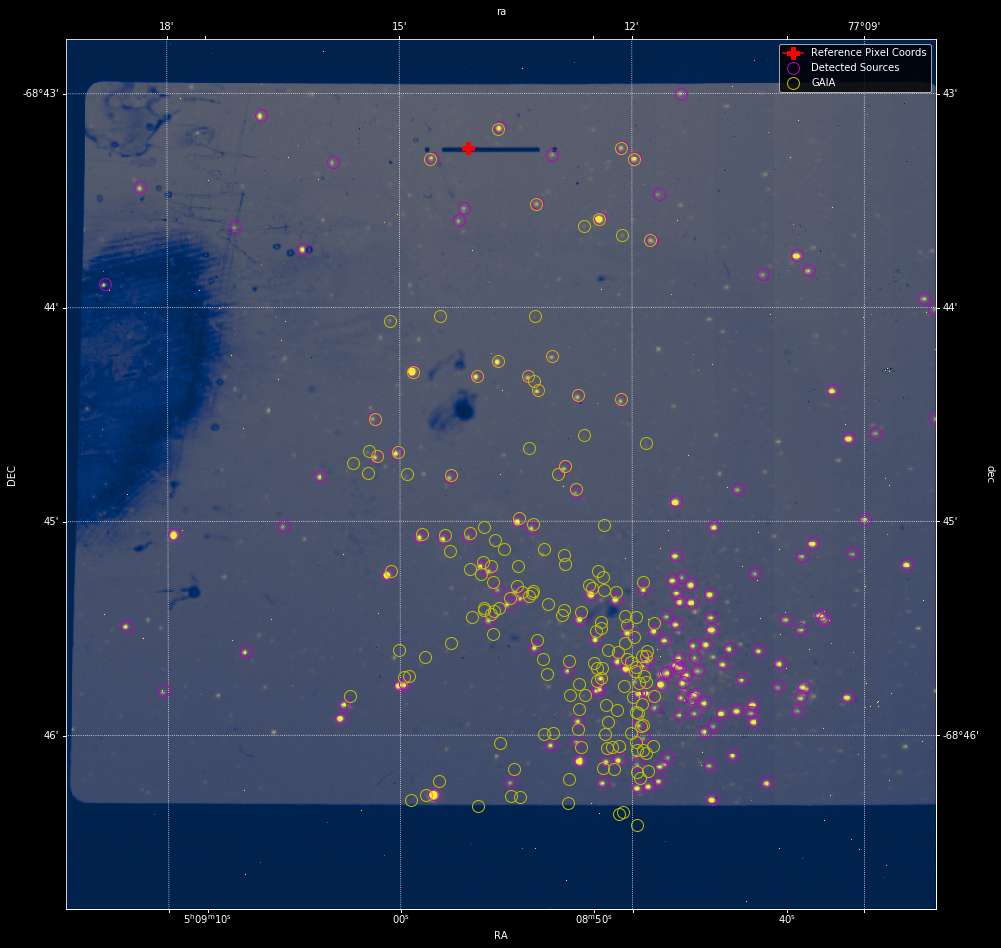

In [543]:
# fig, ax = plt.subplots(figsize=(16,16), subplot_kw={'projection': ccd.wcs})
# scale = ZScaleInterval()

# z1, z2 = scale.get_limits(ccd.data)
ccd_positions = np.transpose(ccd_sky_coords)
ccd_positions
# ax.imshow(ccd.data, clim=(z1, z2), origin='lower', cmap='cividis')
fig  = plt.figure(figsize=(16,16))
ax = plt.subplot(projection=new_wcs)
plt.imshow(ccd.data, clim=(z1, z2), origin='lower', cmap='cividis')
ax.plot(scicoord.ra.deg, scicoord.dec.deg, marker="P", color='r',  markersize=12, label="Reference Pixel Coords", transform=ax.get_transform('icrs'))
# ax.plot(field.ra.deg, field.dec.deg, 'o', mfc='none', markersize=12, transform=ax.get_transform('icrs'))
ax.plot(ccd_sky_coords.ra.deg, ccd_sky_coords.dec.deg, 'o', mfc='none', color='m', markersize=12, label='Detected Sources', transform=ax.get_transform('icrs'))
ax.plot(gaia_sources.ra.deg, gaia_sources.dec.deg, 'o', mfc='none', color='y', markersize=12, transform=ax.get_transform('icrs'), label='GAIA')

plt.xlabel(r'RA')
plt.ylabel(r'DEC')
ax.legend(loc='best')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

In [503]:
# print(np.array(sources['xcentroid'].data))
source_positions = (sources['xcentroid'].data, sources['ycentroid'].data)
print(source_positions)

# wcs = fit_wcs_from_points(xy=source_positions, world_coords=gaia_sources)

NameError: name 'sources' is not defined

In [504]:

gaia_positions = np.transpose((r['ra'], r['dec']))

ccd_positions = np.transpose(ccd_sky_coords)
print(ccd_sky_coords)

field = SkyCoord(ra=ccd_sky_coords['ra'] *u.degree, dec=ccd_sky_coords['dec'] * u.degree)
gaia_catalog = SkyCoord(ra=gaia_sources.ra, dec=gaia_sources.dec)

# idx, d2d, d3d = field.match_to_catalog_sky(gaia_catalog)
idx, d2d, d3d = match_coordinates_sky(field, gaia_catalog)
print(idx)
print(d2d)
print(d3d)
matches = gaia_catalog[idx]
print(matches)
new_ra, new_dec = field.spherical_offsets_to(matches)
print(new_ra.deg)
print(field.ra.deg)
# print((matches.separation_3d(field) == d3d).all())
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))
ax1.set_title('GAIA Sources')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.plot(gaia_sources.ra, gaia_sources.dec, 'o', markersize=12)
ax1.plot(field.ra.deg + new_ra.deg , field.dec.deg + new_dec.deg, '1', color='red', markersize=12)
# ax1.plot(new_ra, new_dec, 'o', color='magenta', markersize=12)
# sub_data = [int(y_box_fitted.x_0.value - y_box_fitted.width.value / 2.):int(y_box_fitted.x_0.value + y_box_fitted.width.value / 2.),int(x_box_fitted.x_0.value - x_box_fitted.width.value / 2.):int(x_box_fitted.x_0.value + x_box_fitted.width.value / 2.)]
ax2.imshow(ccd.data, origin='lower', norm=norm,
           interpolation='nearest')
ax2.set_ylim(int(y_box_fitted.x_0.value - y_box_fitted.width.value / 2.), int(y_box_fitted.x_0.value + y_box_fitted.width.value / 2.))
ax2.set_xlim(int(x_box_fitted.x_0.value - x_box_fitted.width.value / 2.), int(x_box_fitted.x_0.value + x_box_fitted.width.value / 2.))
apertures.plot(color='red', lw=3)
# apertures = CircularAperture(gaia_positions, r=5.)
# apertures.plot(color='white', lw=1.5, alpha=0.5)

<SkyCoord (ICRS): (ra, dec) in deg
    [(77.31355126, -68.73146719), (77.13477457, -68.74189313),
     (77.13498174, -68.73335329), (77.22607665, -68.77033331),
     (77.19875654, -68.76888109), (77.16851499, -68.76286191),
     (77.21184408, -68.76714169), (77.16427218, -68.7646773 ),
     (77.18242179, -68.76589326), (77.22884853, -68.75525669),
     (77.19219686, -68.76839341), (77.28541794, -68.72696828),
     (77.19743662, -68.76683571), (77.17343777, -68.75399714),
     (77.17188069, -68.73067468), (77.14755787, -68.74304507),
     (77.19434881, -68.72439874), (77.23524348, -68.75115156),
     (77.17724997, -68.74743221), (77.27506203, -68.75032095),
     (77.30093399, -68.76312314), (77.21214259, -68.74771958),
     (77.21723402, -68.72136866), (77.15247595, -68.75245651),
     (77.17425229, -68.76484333), (77.20628127, -68.77035623),
     (77.25568057, -68.7419183 ), (77.19849659, -68.76582432),
     (77.18925574, -68.7542937 ), (77.21742263, -68.7674113 ),
     (77.21386459, -

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [505]:
print(gaia_sources)

<SkyCoord (ICRS): (ra, dec) in deg
    [(77.22227911, -68.74428217), (77.22444229, -68.74975234),
     (77.23897582, -68.74641376), (77.21604592, -68.74634556),
     (77.23182736, -68.75045256), (77.22136176, -68.75020068),
     (77.21453248, -68.74566084), (77.22946513, -68.75145631),
     (77.23491101, -68.7509416 ), (77.22752025, -68.75217859),
     (77.21207225, -68.7475198 ), (77.24030349, -68.75107706),
     (77.21896217, -68.75219653), (77.23222036, -68.75314381),
     (77.22034646, -68.73975352), (77.21031572, -68.7433156 ),
     (77.23929375, -68.75233975), (77.23043939, -68.75352505),
     (77.22454178, -68.75350088), (77.24849994, -68.7463478 ),
     (77.22102651, -68.73907454), (77.24526304, -68.75099537),
     (77.23346597, -68.73867411), (77.22237819, -68.73870361),
     (77.23491176, -68.75371257), (77.21471353, -68.75263287),
     (77.23253894, -68.75413365), (77.25046225, -68.74461787),
     (77.21168757, -68.74020258), (77.23008108, -68.75473958),
     (77.21457737, -

In [506]:
print(dir(apertures))
print(apertures.positions)

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_centered_edges', '_default_patch_properties', '_define_patch_params', '_do_photometry', '_make_annulus_path', '_positions_str', '_shape_params', '_to_patch', '_to_sky_params', '_translate_mask_mode', '_xy_extents', 'area', 'bbox', 'bounding_boxes', 'do_photometry', 'isscalar', 'plot', 'positions', 'r', 'shape', 'theta', 'to_mask', 'to_sky']
[[ 41.23296117 674.39974981]
 [938.91119218 529.87917504]
 [938.06391694 648.12462594]
 [480.49813308 136.50038255]
 [617.48745784 156.5572037 ]
 [769.21266107 239.7725045 ]
 [551.87411588 180.67325886]
 [790.46336115 214.61247683]
 [69